# Anomaly detection

这部分，您将实现一个异常检测算法来检测服务器计算机中的异常行为。他的特征是测量每个服务器的响应速度(mb/s)和延迟(ms)。当你的服务器运行时，你收集到了m=307的样本，是无标签的。你相信其中绝大多数样本是正常的，但还是有一小部分的样本是异常的。

我们将使用高斯分布模型来检测数据集中的异常样本。

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio

F:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
data1 = sio.loadmat('./ex8/ex8data1.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [6]:
X = data1['X']
Xval = data1['Xval']
yval = data1['yval']
X.shape, Xval.shape, yval.shape

((307, 2), (307, 2), (307, 1))

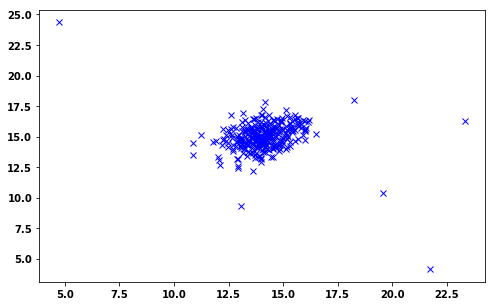

In [7]:
def plot_data():
    plt.figure(figsize=(8,5))
    plt.plot(X[:,0], X[:,1], 'bx')
plot_data()

## Gaussian distribution

要执行异常检测，首先需要将模型拟合数据的分布。

给定训练集x(1),...,x(m), 我们想要对每个特征xi做高斯分布估计。对于每个特征，i=1...n ，我们需要找到参数 ui,δi^2来拟合数据。

$$ p(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}} $$

$$ p(x) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}exp(-\frac{1}{2}(x - \mu)^T \Sigma^{-1}(x - \mu)) $$

In [13]:
# np.diag(array)
# array是一个1维数组时，结果形成一个以一维数组为对角线元素的矩阵
# array是一个二维矩阵时，结果输出矩阵的对角线元素

# np.linalg.det()：矩阵求行列式（标量）

def gaussian(X, mu, sigma2):
    """
    mu, sigma2参数决定了一个高斯分布模型
    """
    m, n = X.shape
    if np.ndim(sigma2) == 1: # 检测维度
        sigma2 = np.diag(sigma2)
        
    norm = 1 / (np.power((2*np.pi), n/2)*np.sqrt(np.linalg.det(sigma2)))
    exp = np.zeros((m,1))
    for row in range(m):
        xrow = X[row]
        exp[row] = np.exp(-0.5*((xrow-mu).T).dot(np.linalg.inv(sigma2)).dot(xrow - mu))
    return norm * exp 

## Estimating parameters for a Gaussian

参数估计：
$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)} $$

$$ \sigma_i^2 =  \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2 $$

In [20]:
def gaussian_params(X, use_multi_variate):
    mu = X.mean(axis=0)
    if use_multi_variate:
        sigma2 = ((X - mu).T @ (X - mu)) / len(X)
    else:
        sigma2 = X.var(axis=0, ddof=0) # 样本差
    return mu, sigma2

In [21]:
def plot_contours(mu, sigma2):
    """
    画出高斯概率分布的图，在三维中是一个上凸的曲面。投影到平面上则是一圈圈的等高线。
    """
    delta = 0.3
    x = np.arange(0,30,delta)
    y = np.arange(0,30,delta)
    
    # 这部分要转化为X形式的坐标矩阵，也就是一列是横坐标，一列是纵坐标，
    # 然后才能传入gaussian中求解得到每个点的概率值
    xx, yy = np.meshgrid(x, y)
    points = np.c_[xx.ravel(), yy.ravel()]  # 按列合并，一列横坐标，一列纵坐标
    z = gaussian(points, mu, sigma2)
    z = z.reshape(xx.shape)  
    
    cont_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, z, cont_levels)  # 这个levels是作业里面给的参考,或者通过求解的概率推出来。

    plt.title('Gaussian Contours',fontsize=16)

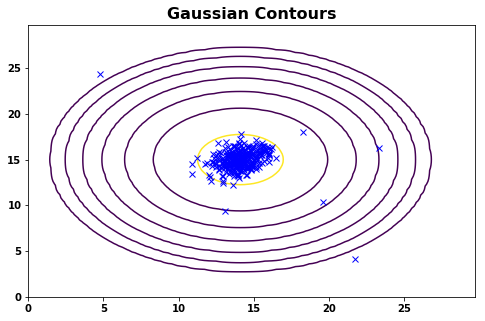

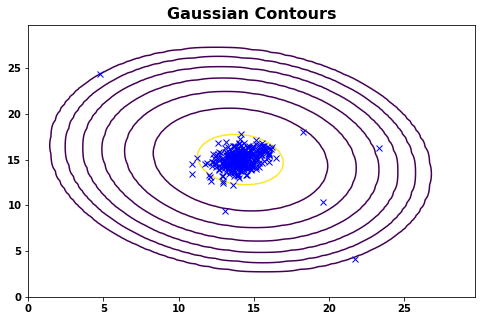

In [24]:
plot_data()
use_mv = False
plot_contours(*gaussian_params(X, use_mv))

plot_data()
use_mv = True
plot_contours(*gaussian_params(X, use_mv))

从上面的图可以看到，一元高斯模型仅在横向和纵向上有变化，而多元高斯模型在斜轴上也有相关变化，对应着特征间的相关关系。而一元高斯模型就是多元高斯模型中协方差矩阵为对角矩阵的结果，即协方差都为0，不考虑协方差，只考虑方差，故一元高斯模型不会有斜轴上的变化。

从上面的图我们可以清晰的看到，哪些样本的概率高，哪些样本的概率低，概率低的样本很大程度上就是异常值。

## Selecting the threshold, ε

确定哪些例子是异常的一种方法是通过一组交叉验证集，选择一个好的阈值 ε 。

在这部分的练习中,您将实现一个算法使用交叉验证集的F1分数来选择合理的阈值 ε 。

$$ prec = \frac{tp}{tp+fp} $$
$$ rec = \frac{tp}{tp+fn} $$
$$ F_1 = \frac{2*prec*rec}{prec + prec} $$